In [41]:
#Загружаем библиотеки
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, SimpleRNN 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
import time
import keras
from sklearn.metrics import mean_squared_error
import math
%matplotlib inline

In [42]:
# Подключаем Диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
base_data = pd.read_csv('/content/drive/My Drive/datasets/date_csv/AAPL.csv')
base_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1981-01-02,0.154018,0.155134,0.154018,0.154018,0.120319,21660800.0
1,1981-01-05,0.151228,0.151228,0.150670,0.150670,0.117703,35728000.0
2,1981-01-06,0.144531,0.144531,0.143973,0.143973,0.112472,45158400.0
3,1981-01-07,0.138393,0.138393,0.137835,0.137835,0.107677,55686400.0
4,1981-01-08,0.135603,0.135603,0.135045,0.135045,0.105497,39827200.0


In [44]:
# Загружаем данные
def get_raw_data(index_name,retry_attempts = 3):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except:
                print("Data pull failed. {} retry attempts remaining".\
                      format(retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None

,High,Low,Open,Close,Volume,Adj Close
2015-11-30,29.852501,29.4375,29.497499,29.575001,156721200.0,27.177872
2015-12-01,29.702499,29.2150,29.687500,29.334999,139409600.0,26.957327
2015-12-02,29.527500,29.0200,29.334999,29.070000,133546400.0,26.713804
2015-12-03,29.197500,28.5550,29.137501,28.799999,166278000.0,26.465693
2015-12-04,29.812500,28.7775,28.822500,29.757500,231108000.0,27.345581


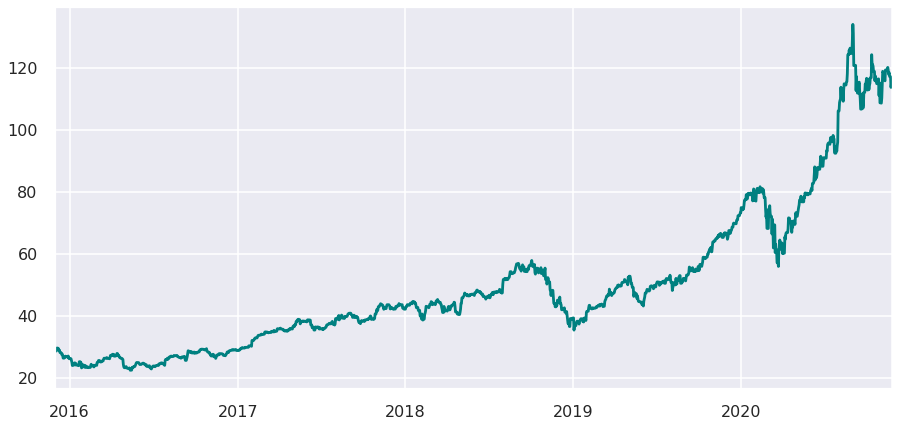

In [45]:
# Просмотр данных
sp_df = get_raw_data('AAPL')
sp_close_series = sp_df.Close
plt.style.use('seaborn-poster')
sp_close_series.plot(figsize=(15, 7), color = 'teal')
sp_df.head()

In [46]:
sp_df.index.min(), sp_df.index.max()

(Timestamp('2015-11-30 00:00:00', freq='D'),
 Timestamp('2020-11-25 00:00:00', freq='D'))

In [47]:
# Подготавливаем, нормализуем, делим на выборки
WINDOW = 6
PRED_LENGTH = int(WINDOW/2)

def get_reg_train_test(timeseries,sequence_length= 51,
                   train_size=0.9,roll_mean_window=5,
                   normalize=True,scale=False):

    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
    
    result = []
    for index in range(len(timeseries) - sequence_length):
        result.append(timeseries[index: index + sequence_length])
           
    if normalize:
        normalised_data = []
        for window in result:
            normalised_window = [((float(p) / float(window[0])) - 1) \
                                   for p in window]
            normalised_data.append(normalised_window)
        result = normalised_data
    
    result = np.array(result) 
    row = round(train_size * result.shape[0])
    
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    scaler = None
    if scale:
        scaler=MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
      
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))            
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
    return x_train,y_train,x_test,y_test,scaler


In [48]:
# Делим данные
x_train,y_train,x_test,y_test,scaler = get_reg_train_test(sp_close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)

In [49]:
print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

x_train shape=(1634, 6, 1)
y_train shape=(1634,)
x_test shape=(182, 6, 1)
y_test shape=(182,)


In [50]:
# Функция создания сетки
def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):

    model = Sequential()
    model.add(LSTM(layer_units[0], input_shape=(window_size,1), return_sequences=True))
    model.add(Dropout(dropouts[0]))
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))

    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model

lstm_model=None
try:
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)   
except:
    print("Model Build Failed. Trying Again")
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)

> Compilation Time :  0.008159637451171875
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 6, 50)             10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 50)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_______

In [51]:
# Обучение сети
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0)]
                                                                 
lstm_model.fit(x_train, y_train, epochs=20, batch_size=16, verbose=1,validation_split=0.05, callbacks=callbacks)
        

Epoch 1/20
97/97 [==============================] - 1s 11ms/step - loss: 6.2026e-04 - val_loss: 0.0014
Epoch 2/20
97/97 [==============================] - 0s 5ms/step - loss: 3.4779e-04 - val_loss: 0.0011
Epoch 3/20
97/97 [==============================] - 0s 5ms/step - loss: 2.6838e-04 - val_loss: 0.0010
Epoch 4/20
97/97 [==============================] - 0s 5ms/step - loss: 2.3291e-04 - val_loss: 0.0010
Epoch 5/20
97/97 [==============================] - 0s 5ms/step - loss: 2.2089e-04 - val_loss: 0.0010
Epoch 6/20
97/97 [==============================] - 0s 5ms/step - loss: 2.2397e-04 - val_loss: 0.0010
Epoch 7/20
97/97 [==============================] - 0s 5ms/step - loss: 2.1116e-04 - val_loss: 0.0010


In [52]:
# Проверяем модель на обучающей выборке
def predict_reg_multiple(model, data, window_size=6, prediction_len=3):
    prediction_list = []
    for window in range(int(len(data)/prediction_len)):
        _seq = data[window*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(_seq[np.newaxis,:,:])[0,0])
            _seq = _seq[1:]
            _seq = np.insert(_seq, [window_size-1], predicted[-1], axis=0)
        prediction_list.append(predicted)
    return prediction_list


train_pred_seqs = predict_reg_multiple(lstm_model, x_train, window_size=WINDOW, prediction_len=PRED_LENGTH)
train_offset = y_train.shape[0] - np.array(train_pred_seqs).flatten().shape[0]
train_rmse = math.sqrt(mean_squared_error(y_train[train_offset:], 
                                          np.array(train_pred_seqs).\
                                          flatten()))
print('Train Score: %.2f RMSE' % (train_rmse))

Train Score: 0.03 RMSE


In [53]:
# Проверяем модель на тестовой выборке
test_pred_seqs = predict_reg_multiple(lstm_model, x_test, window_size=WINDOW,prediction_len=PRED_LENGTH)                                    
test_offset = y_test.shape[0] - np.array(test_pred_seqs).flatten().shape[0]
test_rmse = math.sqrt(mean_squared_error(y_test[test_offset:], 
                                          np.array(test_pred_seqs).\
                                          flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

Test Score: 0.05 RMSE


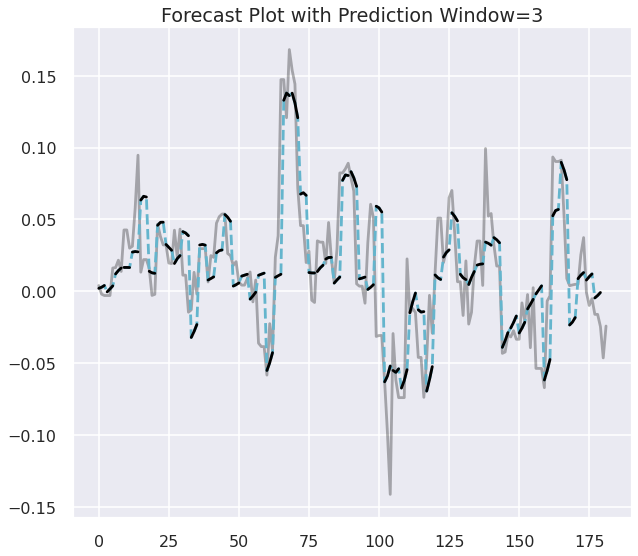

In [54]:
# Отображение результатов
def plot_reg_results(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white', figsize=(10, 9))
    ax = fig.add_subplot(111)
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    plt.plot(np.array(predicted_data).flatten(), 
             label='Prediction_full',
             c='c',linestyle='--')
    
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction Window={}".format(prediction_len))
    plt.show()

plot_reg_results(test_pred_seqs,y_test,prediction_len=PRED_LENGTH)